In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
from subprocess import check_output
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit

# **Tables**

## **train.csv**
- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

## **test.csv**
- id: row id (will be used for submission)
- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.

## **sample_submission.csv**
sample submission file in the format that we expect you to submit
- id: same as id in test.csv
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

## **songs.csv**
The songs. Note that data is in unicode.
- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language

## **members.csv**
user information.
- msno
- city
- bd: age. Note: this column has outlier values, please use your judgement.
- gender
- registered_via: registration method
- registration_init_time: format %Y%m%d
- expiration_date: format %Y%m%d

## **song_extra_info.csv**
- song_id
- song name - the name of the song.
- isrc - International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.`

# loading data

In [2]:
print('Loading data...')
data_path = 'input/'
train = pd.read_csv(data_path + 'train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv(data_path + 'test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv(data_path + 'songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv(data_path + 'members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'})
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')

Loading data...


# Data preprocessing

In [3]:
print('Data preprocessing...')
song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
train = train.merge(songs[song_cols], on='song_id', how='left')
test = test.merge(songs[song_cols], on='song_id', how='left')


members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['registration_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['expiration_day'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))

# Convert date to number of days
members['membership_days'] = ((pd.to_datetime(members['expiration_date'],format='%Y%m%d') - pd.to_datetime(members['registration_init_time'],format='%Y%m%d'))/ np.timedelta64(1, 'D')).astype(int)
# # members = members.drop(['registration_init_time'], axis=1)


Data preprocessing...


In [4]:
members

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_year,registration_month,registration_date,expiration_year,expiration_month,expiration_day,membership_days
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920,2011,8,20,2017,9,20,2223
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622,2015,6,28,2017,6,22,725
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712,2016,4,11,2017,7,12,457
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907,2015,9,6,2015,9,7,1
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613,2017,1,26,2017,6,13,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,0,NaN,7,20131111,20170910,2013,11,11,2017,9,10,1399
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,18,male,3,20141024,20170518,2014,10,24,2017,5,18,937
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,0,NaN,7,20130802,20170908,2013,8,2,2017,9,8,1498
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,0,NaN,7,20151020,20170920,2015,10,20,2017,9,20,701


In [5]:
# categorize membership_days 
members['membership_days'] = members['membership_days'].astype('category')

In [6]:
member_cols = ['msno','city','registered_via', 'registration_year', 'expiration_year', 'membership_days']

train = train.merge(members[member_cols], on='msno', how='left')
test = test.merge(members[member_cols], on='msno', how='left')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 15 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                object  
 1   song_id             object  
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              uint8   
 6   artist_name         category
 7   genre_ids           category
 8   song_length         float64 
 9   language            category
 10  city                category
 11  registered_via      category
 12  registration_year   int64   
 13  expiration_year     int64   
 14  membership_days     category
dtypes: category(9), float64(1), int64(2), object(2), uint8(1)
memory usage: 455.2+ MB


In [8]:
songs_extra

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001
...,...,...,...
2295966,hLnetpF6UbPg28sSfXnPE2vsdaGsLvddlXEdJR4VTIA=,Deep Breathing,PLL431720793
2295967,N+6vJ8actKQm0S3Fpf4elipTjoAo9ev28aA5FJN5e40=,In Hiding,US5UL1519827
2295968,pv35uG0ts05mWtirM/AMOWEzbHxIVart5ZzRXqKUY1c=,Il Est Ne Le Divin Enfant,PLL431502294
2295969,QSySnm8jt2Go7byY34/PxsZP6dPCins2j2cyYquNhBo=,The Exodus Song,DEPZ69316095


In [9]:
# song_extra (isrc) Setting and Merge
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
#categorize song_year per 5years

songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

In [10]:
train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')

In [11]:
# Make genre_ids to only one value

# use only first vector of genre
train['genre_ids'] = train['genre_ids'].str.split('|').str[0]

In [12]:
# Except some features
temp_song_length = train['song_length']
train.drop('song_length', axis = 1, inplace = True)
test.drop('song_length',axis = 1 , inplace =True)
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,language,city,registered_via,registration_year,expiration_year,membership_days,song_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Bastille,359,52.0,1,7,2012,2017,2103,2016.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Various Artists,1259,52.0,13,9,2011,2017,2301,1999.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Nas,1259,52.0,13,9,2011,2017,2301,2006.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,Soundway,1019,-1.0,13,9,2011,2017,2301,2010.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,Brett Young,1011,52.0,1,7,2012,2017,2103,2016.0


# Counting by songs

In [13]:
#
song_count = train.loc[:,["song_id","target"]]

# measure repeat count by played songs
song_count1 = song_count.groupby(["song_id"],as_index=False).sum().rename(columns={"target":"repeat_count"})

# count play count by songs
song_count2 = song_count.groupby(["song_id"],as_index=False).count().rename(columns = {"target":"play_count"})

In [14]:
song_repeat = song_count1.merge(song_count2,how="inner",on="song_id")
song_repeat["repeat_percentage"] = round((song_repeat['repeat_count']*100) / song_repeat['play_count'],1)
song_repeat['repeat_count'] = song_repeat['repeat_count'].astype('int')
song_repeat['repeat_percentage'] = song_repeat['repeat_percentage'].replace(100.0,np.nan)
#cuz most of 100.0 are played=1 repeated=1 values. I think it is not fair compare with other played a lot songs

In [15]:
train = train.merge(song_repeat,on="song_id",how="left")
test = test.merge(song_repeat,on="song_id",how="left")

In [16]:
# type cast
test['song_id'] = test['song_id'].astype('category')
test['repeat_count'] = test['repeat_count'].fillna(0)
test['repeat_count'] = test['repeat_count'].astype('int')
test['play_count'] = test['play_count'].fillna(0)
test['play_count'] = test['play_count'].astype('int')

In [17]:
train['repeat_percentage'].replace(100.0,np.nan)
test['repeat_percentage'].replace(100.0,np.nan)
train['repeat_count'].replace(0,np.nan)
test['repeat_count'].replace(0,np.nan)
train['play_count'].replace(0,np.nan)
test['play_count'].replace(0,np.nan)

train

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,language,city,registered_via,registration_year,expiration_year,membership_days,song_year,repeat_count,play_count,repeat_percentage
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Bastille,359,52.0,1,7,2012,2017,2103,2016.0,102,215,47.4
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Various Artists,1259,52.0,13,9,2011,2017,2301,1999.0,1,1,NaN
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Nas,1259,52.0,13,9,2011,2017,2301,2006.0,2,4,50.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,Soundway,1019,-1.0,13,9,2011,2017,2301,2010.0,1,1,NaN
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,Brett Young,1011,52.0,1,7,2012,2017,2103,2016.0,150,412,36.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,Dr. Dre,1259,52.0,4,9,2004,2017,4669,1999.0,32,59,54.2
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,R. City feat. Adam Levine,465,52.0,1,7,2013,2017,1562,2015.0,666,1010,65.9
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),465,3.0,1,7,2013,2017,1562,2015.0,7608,10500,72.5
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,Brad Mehldau Trio,2122,52.0,5,9,2015,2017,948,2007.0,6,11,54.5


# Counting by Artist

In [18]:
artist_count = train.loc[:,["artist_name","target"]]

# measure repeat count by played songs
artist_count1 = artist_count.groupby(["artist_name"],as_index=False).sum().rename(columns={"target":"repeat_count_artist"})

# measure play count by songs
artist_count2 = artist_count.groupby(["artist_name"],as_index=False).count().rename(columns = {"target":"play_count_artist"})

artist_repeat = artist_count1.merge(artist_count2,how="inner",on="artist_name")

In [19]:
artist_repeat["repeat_percentage_artist"] = round((artist_repeat['repeat_count_artist']*100) / artist_repeat['play_count_artist'],1)
artist_repeat['repeat_count_artist'] = artist_repeat['repeat_count_artist'].fillna(0)
artist_repeat['repeat_count_artist'] = artist_repeat['repeat_count_artist'].astype('int')
artist_repeat['repeat_percentage_artist'] = artist_repeat['repeat_percentage_artist'].replace(100.0,np.nan)

In [20]:
#use only repeat_percentage_artist
del artist_repeat['repeat_count_artist']
#del artist_repeat['play_count_artist']

In [21]:
#merge it with artist_name to train dataframe
train = train.merge(artist_repeat,on="artist_name",how="left")
test = test.merge(artist_repeat,on="artist_name",how="left")

In [22]:
del train['artist_name']
del test['artist_name']

# msno count

In [23]:
msno_count = train.loc[:,["msno","target"]]

# count repeat count by played songs
msno_count1 = msno_count.groupby(["msno"],as_index=False).sum().rename(columns={"target":"repeat_count_msno"})

# count play count by songs
msno_count2 = msno_count.groupby(["msno"],as_index=False).count().rename(columns = {"target":"play_count_msno"})

msno_repeat = msno_count1.merge(msno_count2,how="inner",on="msno")

In [24]:
msno_repeat["repeat_percentage_msno"] = round((msno_repeat['repeat_count_msno']*100) / msno_repeat['play_count_msno'],1)
msno_repeat['repeat_count_msno'] = msno_repeat['repeat_count_msno'].fillna(0)
msno_repeat['repeat_count_msno'] = msno_repeat['repeat_count_msno'].astype('int')
# it can be meaningful so do not erase 100.0 

In [25]:
#merge it with msno to train dataframe
train = train.merge(msno_repeat,on="msno",how="left")
test = test.merge(msno_repeat,on="msno",how="left")

In [26]:
del train['msno']
del test['msno']

# Make object to category

In [27]:
import gc
del members, songs; gc.collect();

for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [28]:
train['song_year'] = train['song_year'].astype('category')
test['song_year'] = test['song_year'].astype('category')

In [29]:
train.head()

,song_id,source_system_tab,source_screen_name,source_type,target,genre_ids,language,city,registered_via,registration_year,...,membership_days,song_year,repeat_count,play_count,repeat_percentage,play_count_artist,repeat_percentage_artist,repeat_count_msno,play_count_msno,repeat_percentage_msno
0,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,359,52.0,1,7,2012,...,2103,2016.0,102,215,47.4,1140.0,46.3,2791,5511,50.6
1,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,1259,52.0,13,9,2011,...,2301,1999.0,1,1,NaN,303616.0,51.0,462,622,74.3
2,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,1259,52.0,13,9,2011,...,2301,2006.0,2,4,50.0,289.0,21.5,462,622,74.3
3,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,1019,-1.0,13,9,2011,...,2301,2010.0,1,1,NaN,1.0,NaN,462,622,74.3
4,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1011,52.0,1,7,2012,...,2103,2016.0,150,412,36.4,427.0,37.7,2791,5511,50.6


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 21 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   song_id                   category
 1   source_system_tab         category
 2   source_screen_name        category
 3   source_type               category
 4   target                    uint8   
 5   genre_ids                 category
 6   language                  category
 7   city                      category
 8   registered_via            category
 9   registration_year         int64   
 10  expiration_year           int64   
 11  membership_days           category
 12  song_year                 category
 13  repeat_count              int32   
 14  play_count                int64   
 15  repeat_percentage         float64 
 16  play_count_artist         float64 
 17  repeat_percentage_artist  float64 
 18  repeat_count_msno         int32   
 19  play_count_msno           int64   
 20  re

In [31]:
drop_list = ['repeat_count','repeat_percentage',
             'repeat_percentage_artist',
             'repeat_count_msno','repeat_percentage_msno']
train = train.drop(drop_list,axis=1)
test = test.drop(drop_list,axis=1)

# Train it!

In [32]:
test

,id,song_id,source_system_tab,source_screen_name,source_type,genre_ids,language,city,registered_via,registration_year,expiration_year,membership_days,song_year,play_count,play_count_artist,play_count_msno
0,0,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,458,3.0,1,7,2016,2017,577,2014.0,694,13654.0,142.0
1,1,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,465,3.0,1,7,2016,2017,577,2010.0,6090,115325.0,142.0
2,2,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist,2022,17.0,1,4,2016,2016,7,2010.0,5,989.0,132.0
3,3,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,465,52.0,3,9,2007,2017,3567,2002.0,31,698.0,388.0
4,4,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,873,-1.0,3,9,2007,2017,3567,2011.0,5,180.0,388.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556785,2556785,wJoWzZd7AL+qX9xZWZwRTzGRYg0Lxcl5Pe+9n5hZgAQ=,discover,Online playlist more,online-playlist,1609,52.0,13,9,2010,2017,2491,2017.0,0,0.0,177.0
2556786,2556786,KCJ8BlSfRQRgB7EVuzFvg52AhR8m2fT032MzN5ewbEI=,discover,NaN,online-playlist,458,3.0,13,9,2014,2017,1225,2016.0,0,2678.0,248.0
2556787,2556787,ySDsKJSnhFMESzC9mBhY0hnFEEBWDYx0FOMNcYDLb/A=,discover,NaN,online-playlist,458,3.0,13,9,2014,2017,1225,2016.0,504,1212.0,248.0
2556788,2556788,WXH8kL8e+0H2jY+s2Y6FpHyyHdaMYV3b6yfDa3FAt9U=,discover,NaN,online-playlist,465,3.0,13,9,2014,2017,1225,2017.0,0,0.0,248.0


In [33]:
train.columns

Index(['song_id', 'source_system_tab', 'source_screen_name', 'source_type',
       'target', 'genre_ids', 'language', 'city', 'registered_via',
       'registration_year', 'expiration_year', 'membership_days', 'song_year',
       'play_count', 'play_count_artist', 'play_count_msno'],
      dtype='object')

In [34]:
test['play_count_msno'] = test['play_count_msno'].fillna(0)
test['play_count_msno'] = test['play_count_msno'].astype('int')


train['play_count_artist'] = train['play_count_artist'].fillna(0)
test['play_count_artist'] = test['play_count_artist'].fillna(0)
train['play_count_artist'] = train['play_count_artist'].astype('int')
test['play_count_artist'] = test['play_count_artist'].astype('int')

In [35]:
from sklearn.model_selection import KFold
# Create a Cross Validation with 3 splits
kf = KFold(n_splits=3)

predictions = np.zeros(shape=[len(test)])
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 2**8,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'num_rounds': 80,
        'metric' : 'auc'
    } 
columns=['song_id', 'source_system_tab', 'source_screen_name', 'source_type','genre_ids', 'language', 'city', 'registered_via',
       'registration_year', 'expiration_year', 'membership_days', 'song_year','play_count', 'play_count_artist', 'play_count_msno']
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(train.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

In [36]:
# For each KFold
mean_score = []
i=1
for train_indices ,validate_indices in kf.split(train) : 
    print(f'fold_{i}')
    train_data = lgb.Dataset(train.drop(['target'],axis=1).loc[train_indices,:],label=train.loc[train_indices,'target'])
    val_data = lgb.Dataset(train.drop(['target'],axis=1).loc[validate_indices,:],label=train.loc[validate_indices,'target'])
    # Train the model    
    lgbm_model = lgb.train(params, train_data, 100, valid_sets=[val_data])
    feature_importances[f'fold_{i}'] = lgbm_model.feature_importance()
    y_pred_valid = lgbm_model.predict(train.drop(['target'],axis=1).loc[validate_indices,:],num_iteration=lgbm_model.best_iteration)
    y_oof[validate_indices] = y_pred_valid
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, train.loc[validate_indices,'target']))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    predictions += lgbm_model.predict(test.drop(['id'],axis=1))
    del lgbm_model
    i+=1
    # We get the ammount of predictions from the prediction list, by dividing the predictions by the number of Kfolds.


fold_1


D:\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.72236
[2]	valid_0's auc: 0.731654
[3]	valid_0's auc: 0.740563
[4]	valid_0's auc: 0.742656
[5]	valid_0's auc: 0.743483
[6]	valid_0's auc: 0.744831
[7]	valid_0's auc: 0.746238
[8]	valid_0's auc: 0.74775
[9]	valid_0's auc: 0.748975
[10]	valid_0's auc: 0.749991
[11]	valid_0's auc: 0.749983
[12]	valid_0's auc: 0.75028
[13]	valid_0's auc: 0.751738
[14]	valid_0's auc: 0.752493
[15]	valid_0's auc: 0.753892
[16]	valid_0's auc: 0.754117
[17]	valid_0's auc: 0.755155
[18]	valid_0's auc: 0.75571
[19]	valid_0's auc: 0.755861
[20]	valid_0's auc: 0.755765
[21]	valid_0's auc: 0.756329
[22]	valid_0's auc: 0.756615
[23]	valid_0's auc: 0.756632
[24]	valid_0's auc: 0.756433
[25]	valid_0's auc: 0.756955
[26]	valid_0's auc: 0.757337
[27]	valid_0's auc: 0.757327
[28]	valid_0's auc: 0.757242
[29]	valid_0's auc: 0.75734
[30]	valid_0's auc: 0.757806
[31]	valid_0's auc: 0.757741
[32]	valid_0's auc: 0.757589
[33]	valid_0's auc: 0.757661
[34]	valid_0's auc: 0.757781
[35]	valid_0's auc: 0.757767

D:\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.684509
[2]	valid_0's auc: 0.690216
[3]	valid_0's auc: 0.69428
[4]	valid_0's auc: 0.69635
[5]	valid_0's auc: 0.698075
[6]	valid_0's auc: 0.699705
[7]	valid_0's auc: 0.701082
[8]	valid_0's auc: 0.701904
[9]	valid_0's auc: 0.702668
[10]	valid_0's auc: 0.704576
[11]	valid_0's auc: 0.705629
[12]	valid_0's auc: 0.706452
[13]	valid_0's auc: 0.708269
[14]	valid_0's auc: 0.708496
[15]	valid_0's auc: 0.708814
[16]	valid_0's auc: 0.709199
[17]	valid_0's auc: 0.710344
[18]	valid_0's auc: 0.710496
[19]	valid_0's auc: 0.710642
[20]	valid_0's auc: 0.710821
[21]	valid_0's auc: 0.711407
[22]	valid_0's auc: 0.711831
[23]	valid_0's auc: 0.712225
[24]	valid_0's auc: 0.712701
[25]	valid_0's auc: 0.712959
[26]	valid_0's auc: 0.713007
[27]	valid_0's auc: 0.713303
[28]	valid_0's auc: 0.71351
[29]	valid_0's auc: 0.713725
[30]	valid_0's auc: 0.714441
[31]	valid_0's auc: 0.714583
[32]	valid_0's auc: 0.714584
[33]	valid_0's auc: 0.714725
[34]	valid_0's auc: 0.714729
[35]	valid_0's auc: 0.7148

D:\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.646574
[2]	valid_0's auc: 0.649847
[3]	valid_0's auc: 0.653956
[4]	valid_0's auc: 0.656474
[5]	valid_0's auc: 0.65815
[6]	valid_0's auc: 0.659274
[7]	valid_0's auc: 0.660146
[8]	valid_0's auc: 0.661281
[9]	valid_0's auc: 0.662337
[10]	valid_0's auc: 0.663328
[11]	valid_0's auc: 0.664594
[12]	valid_0's auc: 0.665305
[13]	valid_0's auc: 0.666087
[14]	valid_0's auc: 0.667328
[15]	valid_0's auc: 0.66809
[16]	valid_0's auc: 0.668402
[17]	valid_0's auc: 0.669215
[18]	valid_0's auc: 0.669716
[19]	valid_0's auc: 0.669841
[20]	valid_0's auc: 0.670078
[21]	valid_0's auc: 0.670553
[22]	valid_0's auc: 0.670882
[23]	valid_0's auc: 0.670973
[24]	valid_0's auc: 0.671191
[25]	valid_0's auc: 0.671452
[26]	valid_0's auc: 0.671765
[27]	valid_0's auc: 0.671969
[28]	valid_0's auc: 0.672164
[29]	valid_0's auc: 0.672515
[30]	valid_0's auc: 0.672724
[31]	valid_0's auc: 0.672841
[32]	valid_0's auc: 0.67309
[33]	valid_0's auc: 0.673055
[34]	valid_0's auc: 0.673088
[35]	valid_0's auc: 0.6731

In [38]:
predictions = predictions/3

INPUT_DATA_PATH = 'input/'

# Read the sample_submission CSV
submission = pd.read_csv(INPUT_DATA_PATH + '/sample_submission.csv')
# Set the target to our predictions
submission.target=predictions
# Save the submission file
submission.to_csv('submission.csv',index=False)

In [39]:
mean_score

[0.4559061980879974, 0.4662264181183545, 0.48195303998958106]

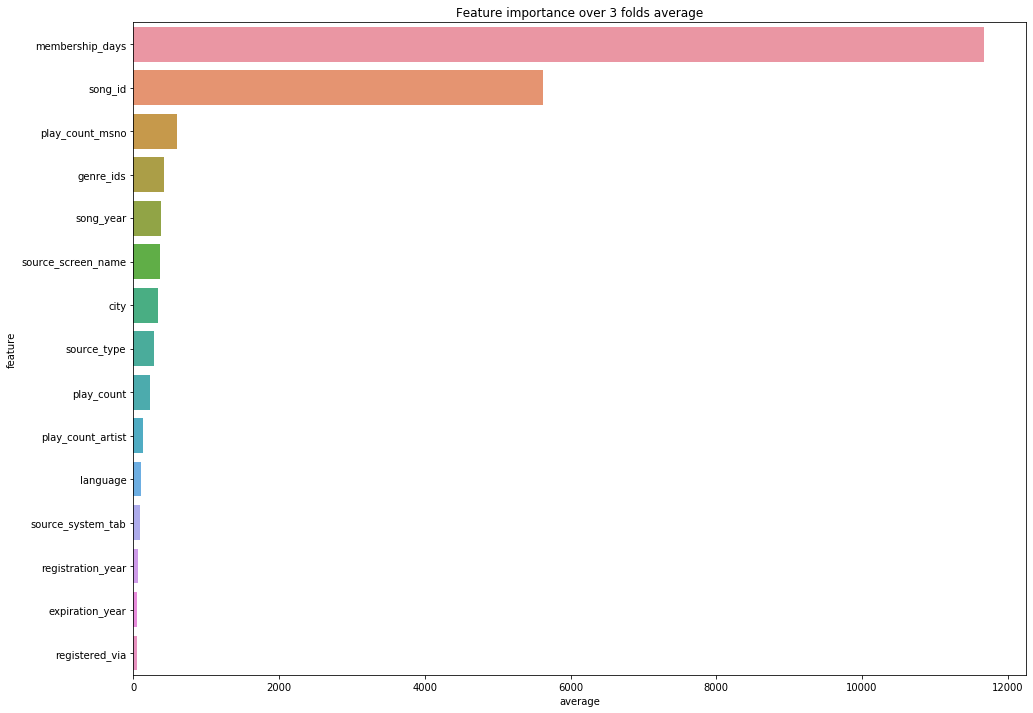

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_importances['average'] = feature_importances[[f'fold_{i+1}' for i in range(3)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature');
plt.title('Feature importance over 3 folds average');